In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import skew

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

These are the customers' details available in the dataset.

 - Variable - Description  
 - Loan_ID - Unique Loan ID  
 - Gender - Male/ Female  
 -  Married - Applicant married (Y/N)  
 -  Dependents - Number of dependents  
 -  Education - Applicant Education (Graduate/ Under Graduate)   
 -  Self_Employed - Self employed (Y/N)  
 -  ApplicantIncome - Applicant income  
 - CoapplicantIncome - Coapplicant income  
 -   LoanAmount - Loan amount in thousands  
 -  Loan_Amount_Term - Term of loan in months  
 -  Credit_History - credit history meets guidelines  
 -  Property_Area - Urban/ Semi Urban/ Rural  
 -  Loan_Status - Loan approved (Y/N)  

## <font color= darkblue> Quick Modelling <font>
    
The idea is to get a basic benchmark and to see which features are important while spending no time on data analysis. This will give a rough estimate, but it is useful.

In [3]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [4]:
#LoanID is just an index, so it isn't useful. LoanID in test data is necessary to create a submission file.
train.drop(['Loan_ID'], axis=1, inplace=True)
test_id = test.Loan_ID
test.drop(['Loan_ID'], axis=1, inplace=True)

In [5]:
for col in train.columns.drop('Loan_Status'):
    if train[col].dtype != 'object':
        if skew(train[col]) > 0.75:
            train[col] = np.log1p(train[col])
        pass
    else:
        dummies = pd.get_dummies(train[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        train.drop(col, axis=1, inplace=True)
        train = train.join(dummies)

for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            test[col] = np.log1p(test[col])
        pass
    else:
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        test.drop(col, axis=1, inplace=True)
        test = test.join(dummies)

In [6]:
X_train = train.drop('Loan_Status', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.Loan_Status.values)
X_test = test

In [7]:
#Estimating feature importance
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

print('Feature Importance:')
for f in range(X_train.shape[1]):
    print('{}. feature {} {} ({})'.format(f+1, indices[f], X_train.columns[indices[f]],
                                             clf.feature_importances_[indices[f]]))

Feature Importance:
1. feature 4 Credit_History (0.2602105471010966)
2. feature 0 ApplicantIncome (0.18335326370517374)
3. feature 2 LoanAmount (0.16766705964605091)
4. feature 1 CoapplicantIncome (0.1070728259058157)
5. feature 3 Loan_Amount_Term (0.045886582735600805)
6. feature 18 Property_Area_Semiurban (0.021375923692320904)
7. feature 9 Dependents_0 (0.019461684154363276)
8. feature 17 Property_Area_Rural (0.019179459308429174)
9. feature 10 Dependents_1 (0.01797563902418592)
10. feature 15 Self_Employed_No (0.01775444298671971)
11. feature 7 Married_No (0.01567704110668721)
12. feature 19 Property_Area_Urban (0.015234440762777942)
13. feature 6 Gender_Male (0.014903744750317038)
14. feature 13 Education_Graduate (0.014688713525535338)
15. feature 5 Gender_Female (0.0142903243510725)
16. feature 16 Self_Employed_Yes (0.014159264419275834)
17. feature 8 Married_Yes (0.013615403510381282)
18. feature 14 Education_Not Graduate (0.013209225946757198)
19. feature 11 Dependents_2 (0.01

Obviously credit history, income, loan amount and loan amount term are important. Other variables have less importance and may be ignored for now.

In [8]:
#I'll use top-5 most important features.
best_features=X_train.columns[indices[0:5]]
X = X_train[best_features]
Xt = X_test[best_features]

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=42)

In [10]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion='gini')
#CalibratedClassifierCV - probability calibration with cross-validation.
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(Xtrain, ytrain)
y_val = calibrated_clf.predict_proba(Xtest)
y_f = [1 if y_val[i][0] < 0.5 else 0 for i in range(len(ytest))]
print('Validation Accuracy:', sum(y_f == ytest) / len(ytest))

Validation Accuracy: 0.7723577235772358


In [11]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion = 'gini')
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X, Y_train)
y_submit = calibrated_clf.predict_proba(Xt)
submission = pd.DataFrame({'Loan_ID':test_id,
                           'Loan_Status':le.inverse_transform([1 if y_submit[i][0] < 0.5 else 0 for i in range(len(Xt))])})
submission.to_csv('Loan.csv', index=False)

This submission had 0.75 accuracy when submitted, which is a good result. Let's see how it can be improved after paying more attention to data.

In [12]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

## <font color= darkblue> Data Exploration <font>

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [15]:
train.describe(include='all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP002098,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


In [16]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


A lot of missing values. I think that the score could be improved by careful imputation of missing values for important features.

## <font color= darkblue> Loan_ID <font>

In [17]:
train.drop(['Loan_ID'], axis=1, inplace=True)
test_id = test.Loan_ID
test.drop(['Loan_ID'], axis=1, inplace=True)

In [18]:
train.Gender.value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

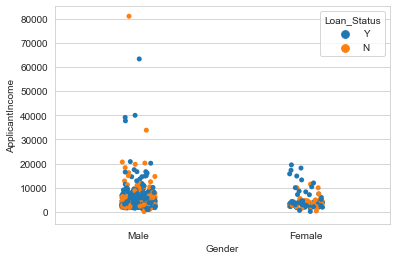

In [19]:
sns.stripplot(x="Gender", y="ApplicantIncome", data=train, hue='Loan_Status', jitter=True);

Much more men than women in the dataset.

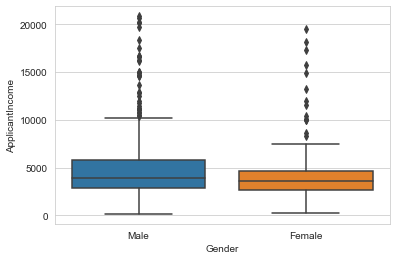

In [20]:
sns.boxplot(x='Gender', y='ApplicantIncome',  data=train.loc[train.ApplicantIncome < 25000]);

In this boxplot I showed distribution of income between genders with income < 25000, as only men have higher income. The difference of income isn't high.

In [21]:
train.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)

Gender  Loan_Status
Female  Y              0.669643
        N              0.330357
Male    Y              0.693252
        N              0.306748
Name: Loan_Status, dtype: float64

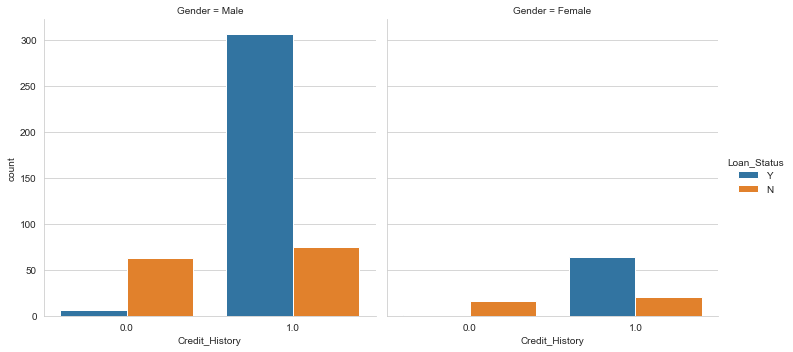

In [23]:
sns.catplot(x="Credit_History", hue="Loan_Status", col="Gender", data=train, kind="count");

Cosidering all this information I'll fill nan with the most common value.

In [24]:
train['Gender'].fillna('Male', inplace=True)
test['Gender'].fillna('Male', inplace=True)

## <font color='Darkblue'>Married<font>

In [25]:
train.Married.value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [26]:
 pd.crosstab(train.Married, train.Loan_Status)

Loan_Status,N,Y
Married,,
No,79,134
Yes,113,285


In [27]:
train.groupby(['Gender'])['Married'].value_counts(normalize=True)

Gender  Married
Female  No         0.720721
        Yes        0.279279
Male    Yes        0.734000
        No         0.266000
Name: Married, dtype: float64

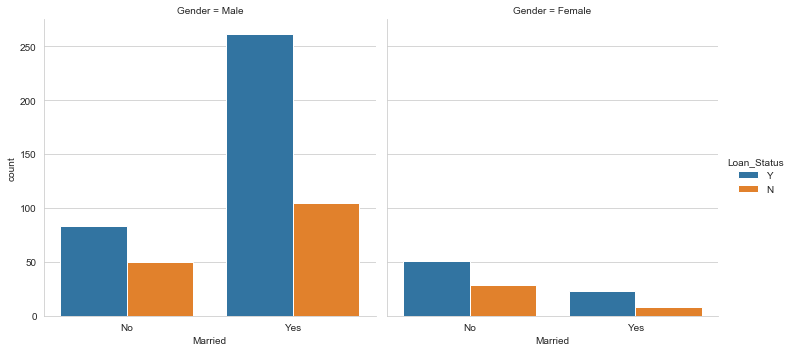

In [28]:
sns.catplot(x="Married", hue="Loan_Status", col="Gender", data=train, kind="count");

Women are less likely to be married than men.

In [29]:
train.loc[train.Married.isnull() == True]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


Two men and one woman. Fillna with most common value for gende

In [30]:
train.loc[(train.Gender == 'Male') & (train.Married.isnull() == True), 'Married'] = 'Yes'
train.loc[(train.Gender == 'Female') & (train.Married.isnull() == True), 'Married'] = 'No'

## <font color='Darkblue'>Dependents<font>

In [31]:
train.Dependents.value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [32]:
train.groupby(['Dependents'])['Loan_Status'].value_counts(normalize=True)

Dependents  Loan_Status
0           Y              0.689855
            N              0.310145
1           Y              0.647059
            N              0.352941
2           Y              0.752475
            N              0.247525
3+          Y              0.647059
            N              0.352941
Name: Loan_Status, dtype: float64

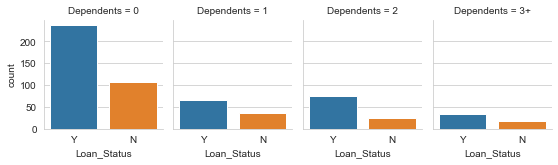

In [34]:
sns.catplot("Loan_Status", col="Dependents", col_wrap=4, data=train, kind="count", height=2.4, aspect=.8);

Most common number of Dependents is zero. And people having 2 Dependents are more likely to get the loan

In [38]:
train['Dependents'] = train['Dependents'].fillna(train['Dependents'].mode().iloc[0])
test['Dependents'] = test['Dependents'].fillna(test['Dependents'].mode().iloc[0])

## <font color='Darkblue'>Education<font>

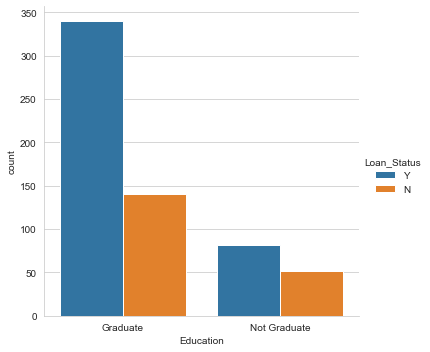

In [40]:
sns.catplot(x="Education", hue="Loan_Status", data=train, kind="count");

It isn't surprising that graduates have more chances to get the loan

## <font color='Darkblue'>Self_Employed<font>

In [41]:
train.groupby(['Self_Employed'])['Loan_Status'].value_counts(normalize=True)

Self_Employed  Loan_Status
No             Y              0.686000
               N              0.314000
Yes            Y              0.682927
               N              0.317073
Name: Loan_Status, dtype: float64

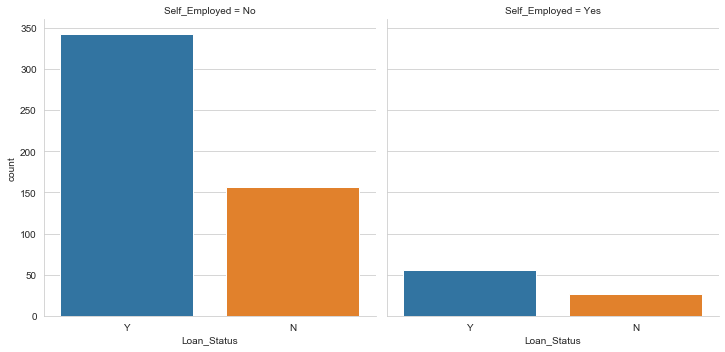

In [45]:
sns.catplot(x='Loan_Status', col='Self_Employed', data=train, kind='count');

In [47]:
train.Self_Employed.value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [48]:
train['Self_Employed'].fillna('No', inplace=True)
test['Self_Employed'].fillna('No', inplace=True)

## <font color='Darkblue'>ApplicantIncome<font>

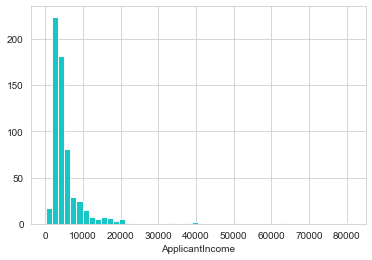

In [49]:
sns.distplot(train['ApplicantIncome'], kde=False, color='c', hist_kws={'alpha': 0.9});

The values are highly skewered. Logarithm of data looks better

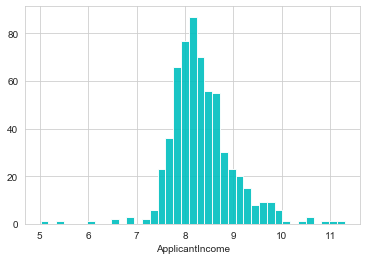

In [50]:
sns.distplot(np.log1p(train['ApplicantIncome']), kde=False, color='c', hist_kws={'alpha': 0.9});

I  think that maybe income could be divided in several groups, and these groups could have various rates of getting loan. I begin with 10 groups and if some groups have much higher/lower rate, then groups could be combined.

In [51]:
train['Income_group'] = pd.qcut(train.ApplicantIncome, 10, labels=[0,1,2,3,4,5,6,7,8,9])
test['Income_group'] = pd.qcut(test.ApplicantIncome, 10, labels=[0,1,2,3,4,5,6,7,8,9])

In [52]:
train['Income_group'] = train['Income_group'].astype(str)
test['Income_group'] = test['Income_group'].astype(str)

In [53]:
train.groupby(['Income_group'])['Loan_Status'].value_counts(normalize=True)

Income_group  Loan_Status
0             Y              0.661290
              N              0.338710
1             Y              0.721311
              N              0.278689
2             Y              0.704918
              N              0.295082
3             Y              0.709677
              N              0.290323
4             Y              0.639344
              N              0.360656
5             Y              0.737705
              N              0.262295
6             Y              0.612903
              N              0.387097
7             Y              0.721311
              N              0.278689
8             Y              0.688525
              N              0.311475
9             Y              0.677419
              N              0.322581
Name: Loan_Status, dtype: float64

This doesn't seem to be a good feature sadly. We'll see later

## <font color='Darkblue'>CoapplicantIncome<font>

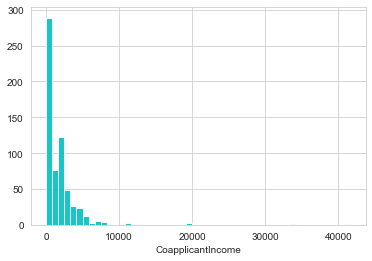

In [56]:
sns.distplot(train['CoapplicantIncome'], kde=False, color='c', hist_kws={'alpha': 0.9});

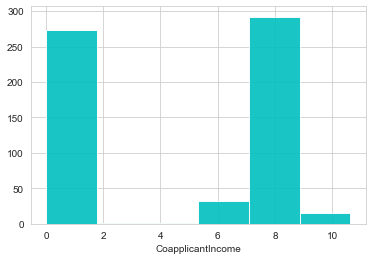

In [57]:
sns.distplot(np.log1p(train['CoapplicantIncome']), kde=False, color='c', hist_kws={'alpha': 0.9});

This variable is also skewered, but logarithm isn't much better. The data has bimodal distribution, so let's divide it into two groups

In [58]:
train['Coap_group'] =  pd.qcut(train.CoapplicantIncome, 2, labels=[0,1])
test['Coap_group'] =  pd.qcut(test.CoapplicantIncome, 2, labels=[0,1])

In [59]:
train['Coap_group'] = train['Coap_group'].astype(str)
test['Coap_group'] = test['Coap_group'].astype(str)

In [60]:
train.groupby(['Coap_group'])['Loan_Status'].value_counts(normalize=True)

Coap_group  Loan_Status
0           Y              0.677524
            N              0.322476
1           Y              0.697068
            N              0.302932
Name: Loan_Status, dtype: float64

Also not good.

## <font color='Darkblue'>LoanAmount<font>

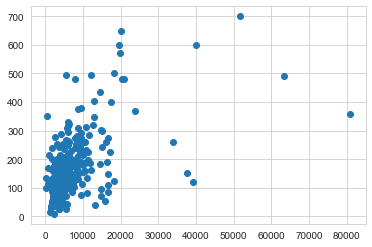

In [62]:
plt.scatter(train['ApplicantIncome'], train['LoanAmount']);

People with higher income want higher loans. Well, this is reasonable.

In [63]:
train['LoanAmount'] = train.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))
test['LoanAmount'] = test.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].apply(lambda x: x.fillna(x.mean()))

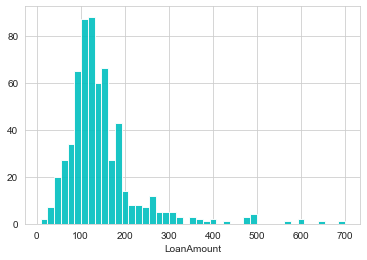

In [64]:
sns.distplot(train['LoanAmount'], kde=False, color='c', hist_kws={'alpha': 0.9});

Loan Amount seems to be more normal than previous variables.

In [66]:
train['Loan_group'] =  pd.qcut(train.LoanAmount, 10, labels=[0,1,2,3,4,5,6,7,8,9])
test['Loan_group'] =  pd.qcut(test.LoanAmount, 10, labels=[0,1,2,3,4,5,6,7,8,9])
train['Loan_group'] = train['Loan_group'].astype(str)
test['Loan_group'] = test['Loan_group'].astype(str)

## <font color='Darkblue'>Loam_Amount_Term<font>

In [67]:
train.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

It seems than this feature is in fact categorical and not continuous.
  But 360 is truly the most common one.

In [68]:
train['Loan_Amount_Term'].fillna(360.0, inplace=True)
test['Loan_Amount_Term'].fillna(360.0, inplace=True)
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype(str)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype(str)

## <font color='Darkblue'>Credit_History<font>

In [69]:
train.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [70]:
train.groupby(['Education', 'Self_Employed', 'Property_Area', 'Income_group'])['Credit_History'].apply(lambda x: x.mode())

Education     Self_Employed  Property_Area  Income_group   
Graduate      No             Rural          0             0    1.0
                                            1             0    1.0
                                            2             0    1.0
                                            3             0    1.0
                                            4             0    1.0
                                            5             0    1.0
                                            6             0    1.0
                                            7             0    1.0
                                            8             0    1.0
                                            9             0    1.0
                             Semiurban      0             0    1.0
                                            1             0    1.0
                                            2             0    1.0
                                            3             0    1.0
  

This is one of key variables. Filling missing values is an important decision. So I'll fill them with mode values based on the grouping higher.



In [72]:
train.loc[(train.Education == 'Graduate') & (train.Self_Employed == 'Yes')
          & (train.Property_Area == 'Urban') & (train.Income_group == '9') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
train.loc[(train.Education == 'Not Graduate') & (train.Self_Employed == 'No')
          & (train.Property_Area == 'Rural') & (train.Income_group == '7') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
train.loc[(train.Education == 'Not Graduate') & (train.Self_Employed == 'No')
          & (train.Property_Area == 'Urban') & (train.Income_group == '2') & (train.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
test.loc[(test.Education == 'Graduate') & (test.Self_Employed == 'Yes')
          & (test.Property_Area == 'Urban') & (test.Income_group == '9') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
test.loc[(test.Education == 'Not Graduate') & (test.Self_Employed == 'No')
          & (test.Property_Area == 'Rural') & (test.Income_group == '7') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
test.loc[(test.Education == 'Not Graduate') & (test.Self_Employed == 'No')
          & (test.Property_Area == 'Urban') & (test.Income_group == '2') & (test.Credit_History.isnull() == True),
          'Self_Employed'] = 0.0
train['Credit_History'].fillna(1.0, inplace=True)
test['Credit_History'].fillna(1.0, inplace=True)
train['Credit_History'] = train['Credit_History'].astype(str)
test['Credit_History'] = test['Credit_History'].astype(str)

## <font color='Darkblue'>Property_Area<font>

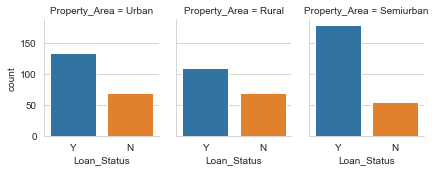

In [73]:
sns.catplot('Loan_Status', col='Property_Area', col_wrap=3, data=train, kind='count', size=2.5, aspect=.8);

It seems that people living in Semiurban area have more chances to get loans

## <font color='Darkblue'>Data Preparation<font>

In [76]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term      object
Credit_History        object
Property_Area         object
Loan_Status           object
Income_group          object
Coap_group            object
Loan_group            object
dtype: object

In [77]:
for col in train.columns.drop('Loan_Status'):
    if train[col].dtype != 'object':
        if skew(train[col]) > 0.75:
            train[col] = np.log1p(train[col])
        pass
    else:
        dummies = pd.get_dummies(train[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        if col == 'Credit_History' or col == 'Loan_Amount_Term':
            pass
        else:
            train.drop(col, axis=1, inplace=True)
        train = train.join(dummies)
for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            test[col] = np.log1p(test[col])
        pass
    else:
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        if col == 'Credit_History' or col == 'Loan_Amount_Term':
            pass
        else:
            test.drop(col, axis=1, inplace=True)
        test = test.join(dummies)

In [78]:
#I leave these two variables as they seem to be important by themselves.
train['Credit_History'] = train['Credit_History'].astype(float)
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].astype(float)
test['Credit_History'] = test['Credit_History'].astype(float)
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].astype(float)

In [79]:
X_train = train.drop('Loan_Status', axis=1)
le = LabelEncoder()
Y_train = le.fit_transform(train.Loan_Status.values)
X_test = test

In [80]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%d. feature %d %s (%f)' % (f + 1, indices[f], X_train.columns[indices[f]],
                                      clf.feature_importances_[indices[f]]))

Feature ranking:
1. feature 0 ApplicantIncome (0.107080)
2. feature 28 Credit_History_0.0 (0.100855)
3. feature 2 LoanAmount (0.099357)
4. feature 4 Credit_History (0.094124)
5. feature 29 Credit_History_1.0 (0.078202)
6. feature 1 CoapplicantIncome (0.065020)
7. feature 30 Property_Area_Rural (0.019249)
8. feature 31 Property_Area_Semiurban (0.018700)
9. feature 3 Loan_Amount_Term (0.018241)
10. feature 9 Dependents_0 (0.015734)
11. feature 39 Income_group_6 (0.015656)
12. feature 10 Dependents_1 (0.015234)
13. feature 32 Property_Area_Urban (0.015013)
14. feature 8 Married_Yes (0.013955)
15. feature 52 Loan_group_7 (0.013553)
16. feature 7 Married_No (0.012798)
17. feature 13 Education_Graduate (0.012372)
18. feature 5 Gender_Female (0.012370)
19. feature 38 Income_group_5 (0.011439)
20. feature 50 Loan_group_5 (0.011114)
21. feature 46 Loan_group_1 (0.011085)
22. feature 6 Gender_Male (0.011063)
23. feature 14 Education_Not Graduate (0.010968)
24. feature 44 Coap_group_1 (0.010904)


Well, little changed. The most important variables are the same. Also Credit History is really important.

In [81]:
best_features = X_train.columns[indices[0:6]]
X = X_train[best_features]
Xt = X_test[best_features]

## <font color='Darkblue'>Model<font>

In [83]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=42)

In [84]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion = 'gini')

calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(Xtrain, ytrain)
y_val = calibrated_clf.predict_proba(Xtest)
y_f = [1 if y_val[i][0] < 0.5 else 0 for i in range(len(ytest))]
sum(y_f == ytest) / len(ytest)

0.7560975609756098

In [85]:
clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, criterion = 'gini')
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X, Y_train)
y_submit = calibrated_clf.predict_proba(Xt)

In [86]:
y_pred = le.inverse_transform([1 if y_submit[i][0] < 0.5 else 0 for i in range(len(Xt))])
submission = pd.DataFrame({'Loan_ID':test_id, 'Loan_Status':y_pred})
submission.to_csv('Loan.csv', index=False)